<a href="https://colab.research.google.com/github/v-demydchenko/Python-for-DA/blob/main/EDA_and_deep_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Фінальний проєк/logistics_shipments_dataset.csv', sep=None, engine='python')

# **Попередня обробка даних (EDA)**

In [5]:
#1. Перевіряємо наявність пропущених значень
missing_values = df.isnull().sum()
print(missing_values)

Shipment_ID          0
Origin_Warehouse     0
Destination          0
Carrier              0
Shipment_Date        0
Delivery_Date       32
Weight_kg            0
Cost                41
Status               0
Distance_miles       0
Transit_Days         0
dtype: int64


In [8]:
# 2. Замінемо пропущені значення в колонці Cost на середнє
df['Cost'] = df['Cost'].fillna(df['Cost'].mean())
df['Cost'] = df['Cost'].round(2)
# Перевірка після заміни
print("\nПропущені значення після заміни:")
print(df.isnull().sum())


Пропущені значення після заміни:
Shipment_ID          0
Origin_Warehouse     0
Destination          0
Carrier              0
Shipment_Date        0
Delivery_Date       32
Weight_kg            0
Cost                 0
Status               0
Distance_miles       0
Transit_Days         0
dtype: int64


In [11]:
# 3. Перевіряємо типи даний
data_types = df.dtypes
print(data_types)

Shipment_ID          object
Origin_Warehouse     object
Destination          object
Carrier              object
Shipment_Date        object
Delivery_Date        object
Weight_kg           float64
Cost                float64
Status               object
Distance_miles        int64
Transit_Days          int64
dtype: object


In [12]:
# 4. Перетворюємо 'Delivery_Date' та 'Shipment_Date' з типу 'object' на тип 'datatime'
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])
df['Shipment_Date'] = pd.to_datetime(df['Shipment_Date'])

In [17]:
# Перевіряємо тип
print(df[['Delivery_Date', 'Shipment_Date']].dtypes)

Delivery_Date    datetime64[ns]
Shipment_Date    datetime64[ns]
dtype: object


In [13]:
# 5. Замінемо пропущені значення в колонці 'Delivery_Date' шляхом додавання до колонки 'Shipment_Date' колонки 'Transit_Days'

df['Delivery_Date'] = df.apply(
    lambda row: row['Shipment_Date'] + pd.Timedelta(days=row['Transit_Days']) if pd.isnull(row['Delivery_Date']) else row['Delivery_Date'], axis=1
)

# Перевіряємо результат
print(df[['Shipment_Date', 'Transit_Days', 'Delivery_Date']].head())

  Shipment_Date  Transit_Days Delivery_Date
0    2023-10-02             2    2023-10-04
1    2023-12-06             3    2023-12-09
2    2023-09-18             2    2023-09-20
3    2023-01-26             9    2023-02-04
4    2023-06-03             3    2023-06-06


In [18]:
# Знову перевіряємо наявність пропущених значень
missing_values = df.isnull().sum()
print(missing_values)

Shipment_ID         0
Origin_Warehouse    0
Destination         0
Carrier             0
Shipment_Date       0
Delivery_Date       0
Weight_kg           0
Cost                0
Status              0
Distance_miles      0
Transit_Days        0
dtype: int64


In [19]:
# 6. Основні статистичні показники
summary_statistics = df.describe()
print(summary_statistics)

             Shipment_Date                  Delivery_Date    Weight_kg  \
count                 2000                           2000  2000.000000   
mean   2023-07-05 12:00:00  2023-07-10 02:32:38.400000256    30.184800   
min    2023-01-01 00:00:00            2023-01-03 00:00:00     0.000000   
25%    2023-04-05 18:00:00            2023-04-11 00:00:00    12.300000   
50%    2023-07-07 00:00:00            2023-07-11 12:00:00    20.700000   
75%    2023-10-04 00:00:00            2023-10-08 00:00:00    33.925000   
max    2023-12-31 00:00:00            2024-01-12 00:00:00  5404.200000   
std                    NaN                            NaN   124.967053   

              Cost  Distance_miles  Transit_Days  
count  2000.000000     2000.000000   2000.000000  
mean    205.161565     1275.868000      4.182500  
min      17.890000      101.000000      1.000000  
25%     119.220000      690.250000      3.000000  
50%     199.530000     1262.500000      4.000000  
75%     271.450000     1867

In [20]:
# 7. Перевірка на дублікати
duplicates = df.duplicated().sum()
print(f'Кількість дублікованих рядків: {duplicates}')

Кількість дублікованих рядків: 0


# **Аналіз даних**

***Загальна вартість перевезення 1 кг. вантажу для кожного перевізника***

In [21]:
data_cleaned = df[(df['Weight_kg'] > 0) & (df['Cost'] > 0)]

data_cleaned['Cost_per_kg'] = data_cleaned['Cost'] / data_cleaned['Weight_kg']

carrier_costs = data_cleaned.groupby('Carrier')['Cost_per_kg'].mean().round(2).reset_index()

carrier_costs.sort_values(by='Cost_per_kg', ascending=False)

/tmp/ipython-input-2443425103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Cost_per_kg'] = data_cleaned['Cost'] / data_cleaned['Weight_kg']


,Carrier,Cost_per_kg
5,UPS,17.82
2,FedEx,17.56
4,OnTrac,14.01
1,DHL,13.25
3,LaserShip,13.23
0,Amazon Logistics,11.36
6,USPS,11.03


***Середній час доставки в днях (середній час, який проходить від дати відправлення до дати доставки)***

In [22]:
df['Shipment_Date'] = pd.to_datetime(df['Shipment_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])
df['Delivery_Time'] = (df['Delivery_Date'] - df['Shipment_Date']).dt.days
avg_delivery_time = df['Delivery_Time'].mean()
avg_delivery_time

np.float64(4.606)

***Кореляція між вагою вантажу та витратами на доставку та побудова графіка для візуалізації кореляції***

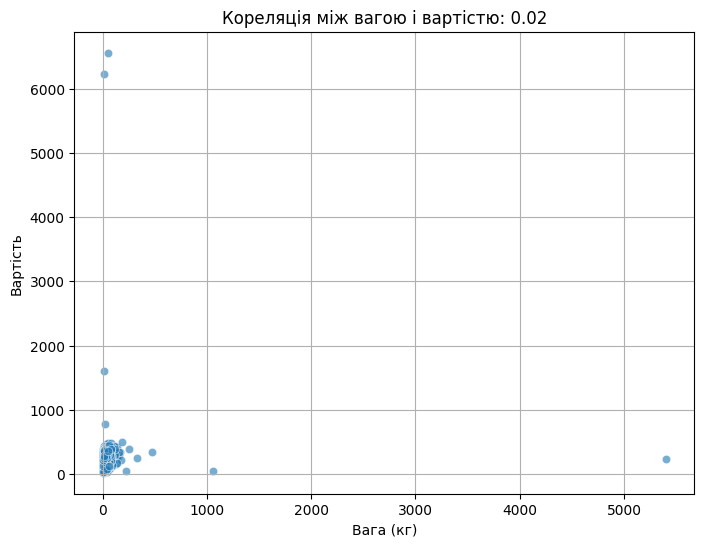

In [23]:
correlation_weight_cost = df[['Weight_kg', 'Cost']].corr().iloc[0, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df['Weight_kg'], df['Cost'], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title(f"Кореляція між вагою і вартістю: {correlation_weight_cost:.2f}")
plt.xlabel("Вага (кг)")
plt.ylabel("Вартість")
plt.grid(True)
plt.show()

Значення кореляції між вагою вантажу та вартістю доставки становить 0.02. Це дуже низьке значення, що вказує на майже відсутність кореляції між цими двома змінними. Тобто, вага вантажу не має значного впливу на вартість доставки.

***Загальна вартість доставки для кожного міста призначення***

In [24]:
total_cost_by_destination = df.groupby('Destination')['Cost'].mean().round(0)
total_cost_by_destination

,Cost
Destination,
Atlanta,189.0
Boston,228.0
Chicago,200.0
Dallas,201.0
Denver,175.0
Detroit,232.0
Houston,205.0
Los Angeles,197.0
Miami,202.0


***Визначаємо найкращого перевізника з урахуванням вартості, часу доставки та частки втрат (Lost)***

            Carrier  shipments  avg_cost  avg_transit_days  lost_rate  score
0              USPS        292    183.51              4.05      0.041  0.980
1            OnTrac        299    184.87              4.12      0.013  0.898
2         LaserShip        303    207.80              4.04      0.033  0.728
3  Amazon Logistics        274    194.20              4.32      0.044  0.574
4             FedEx        295    217.92              4.30      0.020  0.344
5               DHL        281    221.77              4.27      0.004  0.337
6               UPS        256    229.23              4.20      0.000  0.331
Рекомендований перевізник: USPS


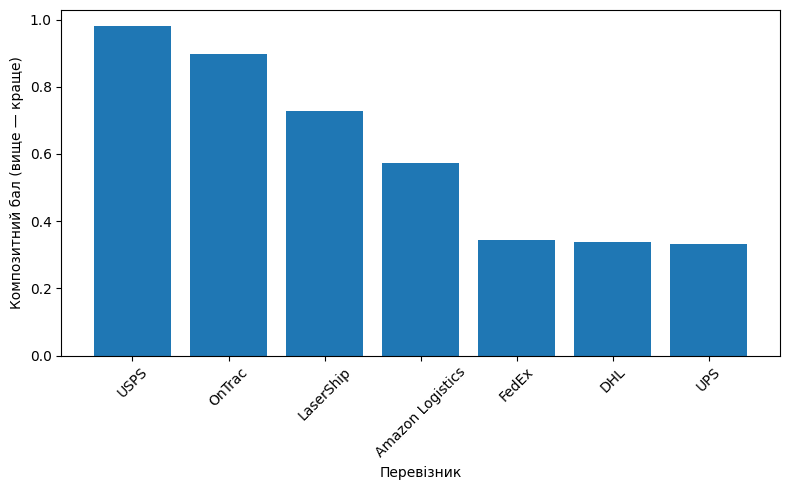

In [25]:
# Сортуємо перевізників за композитним балом з урахуванням вартості, часу доставки та частки втрат (Lost).
# Вищий бал — кращий перевізник
# 1. Агрегації по перевізнику
agg = (
    df.assign(IsLost=df['Status'].str.lower().eq('lost'))
      .groupby('Carrier', as_index=False)
      .agg(
          avg_cost=('Cost', 'mean'),
          avg_transit_days=('Transit_Days', 'mean'),
          lost_rate=('IsLost', 'mean'),
          shipments=('Shipment_ID', 'count')
      )
)

# 2. Безпечна мін-макс нормалізація (0..1)
def minmax(s: pd.Series) -> pd.Series:
    rng = s.max() - s.min()
    return (s - s.min()) / rng if rng != 0 else pd.Series(0.0, index=s.index)

# 3. Оцінки (менше краще - інвертуємо, щоб "більше — краще")
agg['cost_score'] = 1 - minmax(agg['avg_cost'])
agg['time_score'] = 1 - minmax(agg['avg_transit_days'])
# lost_rate уже у [0,1], де 0 — краще (менше втрат). Інвертуємо напряму:
agg['lost_score'] = 1 - agg['lost_rate']

# 4. Ваги критеріїв (налаштовуйте за потреби)
w_cost, w_time, w_lost = 0.5, 0.3, 0.2

# 5. Композитний бал і ранжування
agg['score'] = (
    w_cost * agg['cost_score'] +
    w_time * agg['time_score'] +
    w_lost * agg['lost_score']
)

result = agg.sort_values('score', ascending=False).reset_index(drop=True)

# 6. Вивід таблиці з ключовими метриками
print(
    result[['Carrier', 'shipments', 'avg_cost', 'avg_transit_days', 'lost_rate', 'score']]
    .round({'avg_cost': 2, 'avg_transit_days': 2, 'lost_rate': 3, 'score': 3})
)

# 7. Рекомендований перевізник
best = result.loc[0, 'Carrier']
print(f"Рекомендований перевізник: {best}")

# 8. Графік композитного бала по перевізниках
plt.figure(figsize=(8, 5))
plt.bar(result['Carrier'], result['score'])
plt.ylabel('Композитний бал (вище — краще)')
plt.xlabel('Перевізник')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На даному графіку чітко видно, що лідером стала компанія-перевізник USPS

***Прогнозуємо витрати на доставку для кожного перевізника на основі статусу 'Delivered'***

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1) Функція для прогнозування витрат тільки для статусу "Delivered"
def predict_cost_by_carrier_for_delivered(df):
    # Створення порожнього DataFrame для збереження результатів
    results = []

    # Фільтруємо тільки ті записи, де статус "Delivered"
    delivered_data = df[df['Status'].str.lower() == 'delivered']

    # Унікальні перевізники
    carriers = delivered_data['Carrier'].unique()

    # 2) Тренування моделі для кожного перевізника
    for carrier in carriers:
        carrier_data = delivered_data[delivered_data['Carrier'] == carrier]

        # Перевірка, скільки записів для кожного перевізника зі статусом "Delivered"
        print(f"Перевізник: {carrier}, Кількість записів: {len(carrier_data)}")

        if len(carrier_data) < 2:  # Пропуск перевізників, де мало даних
            continue

        # Вибір ознак для моделі
        features = ['Weight_kg', 'Transit_Days', 'Distance_miles']
        X = carrier_data[features]
        y = carrier_data['Cost']

        # Масштабування числових змінних
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Розподіл на тренувальну і тестову вибірки
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Створення моделі RandomForestRegressor
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Прогнозування на тестовій вибірці
        y_pred = model.predict(X_test)

        # Оцінка моделі
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Додавання фактичних витрат і прогнозованих витрат
        carrier_results = pd.DataFrame({
            'Carrier': [carrier] * len(y_pred),
            'Actual_Cost': y_test,
            'Predicted_Cost': y_pred
        })

        # Додаємо результати в загальний DataFrame
        results.append(carrier_results)

    # Об'єднання результатів в один DataFrame
    final_results = pd.concat(results, ignore_index=True)

    # Підсумкові результати для кожного перевізника
    final_summary = final_results.groupby('Carrier').agg(
        Total_Actual_Cost=('Actual_Cost', 'sum'),
        Total_Predicted_Cost=('Predicted_Cost', 'sum')
    ).reset_index()

    # Повертаємо результат у бажаному форматі
    return final_summary

# Прогнозуємо витрати для кожного перевізника з статусом "Delivered"
predicted_costs = predict_cost_by_carrier_for_delivered(df)

# Виведення результатів у форматі:
# Перевізник, поточні витрати, прогнозовані витрати
print(predicted_costs)

Перевізник: UPS, Кількість записів: 221
Перевізник: DHL, Кількість записів: 231
Перевізник: OnTrac, Кількість записів: 248
Перевізник: FedEx, Кількість записів: 244
Перевізник: Amazon Logistics, Кількість записів: 217
Перевізник: LaserShip, Кількість записів: 248
Перевізник: USPS, Кількість записів: 239
            Carrier  Total_Actual_Cost  Total_Predicted_Cost
0  Amazon Logistics            8889.86             9005.5902
1               DHL            9785.89             9512.5110
2             FedEx           12463.91            11824.0932
3         LaserShip            9453.27            12510.0381
4            OnTrac            8456.34             9005.8092
5               UPS            9126.37            10396.6722
6              USPS            8577.93             9153.4357


In [27]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Фінальний проєк/logistics_shipments_dataset(2).csv', index=False)